# Imports

In [1]:
import os
from glob import glob
from collections import Counter
import pandas as pd
import numpy as np
import pydicom as pydcm

In [2]:
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['figure.figsize'] = (15, 5)

In [4]:
DATASET_DIR = '/mnt/workspace/covid-siim'
DICOM_DIR = '/mnt/data/covid-siim'

# Load metadata

## Utils

For pre-processing

In [29]:
TRAIN_IMAGE_PATHS = glob(os.path.join(DICOM_DIR, 'train/*/*/*.dcm'))
TEST_IMAGE_PATHS = glob(os.path.join(DICOM_DIR, 'test/*/*/*.dcm'))

In [30]:
IMAGE_ID_TO_FPATH = {}

for fpath in TRAIN_IMAGE_PATHS + TEST_IMAGE_PATHS:
    imagename = os.path.basename(fpath).replace('.dcm', '')
    assert imagename not in IMAGE_ID_TO_FPATH, f'Repeated filename: {filename}'
    
    image_fpath = fpath.replace(DICOM_DIR, '').replace('.dcm', '')
    if image_fpath.startswith('/'):
        image_fpath = image_fpath[1:]
    IMAGE_ID_TO_FPATH[imagename] = image_fpath

## Image-level labels

In [31]:
fpath = os.path.join(DATASET_DIR, 'train_image_level.csv')
df_image = pd.read_csv(fpath)
df_image['image_fpath'] = [
    IMAGE_ID_TO_FPATH[image_id.replace('_image', '')]
    for image_id in df_image['id']
]
df_image.head()

,id,boxes,label,StudyInstanceUID,image_fpath
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,train/5776db0cec75/81456c9c5423/000a312787f2
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,train/9d514ce429a7/22897cd1daa0/0012ff7358bc
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,train/28dddc8559b2/4d47bc042ee6/001398f4ff4f
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,train/dfd9fdd85a3e/49170afa4f27/001bd15d1891


In [32]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [33]:
labels_with_bb = list(df_image['label'])
labels = [
    label
    for ll in labels_with_bb
    for label, score, a, b, c, d in tuple(chunks(ll.split(), 6))
]
len(labels)

9893

In [34]:
Counter(labels)

Counter({'opacity': 7853, 'none': 2040})

## Study level labels

In [35]:
fpath = os.path.join(DATASET_DIR, 'train_study_level.csv')
df_study = pd.read_csv(fpath)
df_study['id'] = [s.replace('_study', '') for s in df_study['id']]
df_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1
2,00292f8c37bd,1,0,0,0
3,005057b3f880,1,0,0,0
4,0051d9b12e72,0,0,0,1


In [37]:
COVID_SIIM_DISEASES = [
    'Negative for Pneumonia',
    'Typical Appearance',
    'Indeterminate Appearance',
    'Atypical Appearance',
]

In [38]:
# Check if is multilabel or not
Counter(df_study[COVID_SIIM_DISEASES].sum(axis=1).values)

Counter({1: 6054})

In [39]:
n_studies = len(df_study)
dist_labels = df_study[COVID_SIIM_DISEASES].sum(axis=0).sort_values(ascending=False)
dist_labels

Typical Appearance          2855
Negative for Pneumonia      1676
Indeterminate Appearance    1049
Atypical Appearance          474
dtype: int64

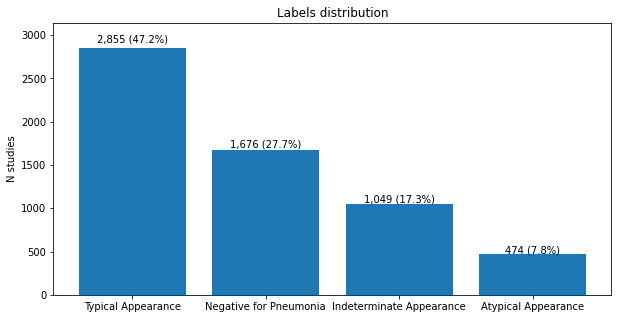

In [46]:
plt.figure(figsize=(10, 5))
plt.title('Labels distribution')
plt.bar(dist_labels.index, dist_labels.values)
plt.ylabel('N studies')
plt.ylim(0, max(dist_labels.values) * 1.10)

for index, value in enumerate(dist_labels.values):
    perc = value / n_studies * 100
    txt = f'{value:,} ({perc:.1f}%)'
    plt.text(index, value * 1.02, txt, ha='center')

### Split studies in train/val

In [47]:
import random

In [48]:
studies = list(df_study['id'])
n_studies = len(studies)
assert n_studies == len(set(studies))
n_studies

6054

In [49]:
val_split = 0.1
n_val_studies = int(n_studies * val_split)
n_train_studies = n_studies - n_val_studies
n_train_studies, n_val_studies

(5449, 605)

In [50]:
val_studies = random.sample(studies, n_val_studies)
train_studies = list(set(studies) - set(val_studies))
assert len(set(val_studies).intersection(train_studies)) == 0
len(train_studies), len(val_studies)

(5449, 605)

In [51]:
def write_list_to_txt(arr, filepath, sep='\n'):
    """Writes a list of strings to a file"""
    with open(filepath, 'w') as f:
        for line in arr:
            f.write(line + sep)

In [135]:
splits_folder = os.path.join(DATASET_DIR, 'splits')
write_list_to_txt(train_studies, os.path.join(splits_folder, 'train.txt'))
write_list_to_txt(val_studies, os.path.join(splits_folder, 'val.txt'))

## Merge into master_metadata.csv

In [40]:
df_study.head(2)

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1


In [41]:
df_image.head(2)

,id,boxes,label,StudyInstanceUID,image_fpath
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,train/5776db0cec75/81456c9c5423/000a312787f2
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f


In [42]:
set(df_study['id']) == set(df_image['StudyInstanceUID'])

True

In [43]:
df_image_2 = df_image.copy()
df_image_2['image_id'] = [i.replace('_image', '') for i in df_image_2['id']]
del df_image_2['id']

In [56]:
master_df = df_image_2.merge(df_study, how='inner', left_on='StudyInstanceUID', right_on='id')
del master_df['id']
master_df.rename(columns={'StudyInstanceUID': 'study_id'}, inplace=True)
master_df.head(2)

,boxes,label,study_id,image_fpath,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,train/5776db0cec75/81456c9c5423/000a312787f2,000a312787f2,0,1,0,0
1,NaN,none 1 0 0 1 1,ff0879eb20ed,train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f,000c3a3f293f,1,0,0,0


In [51]:
assert len(master_df) == len(df_image)

### Add test images to metadata.csv

In [57]:
import re

In [58]:
test_metadata = []
for image_fpath in TEST_IMAGE_PATHS:
    image_id = os.path.basename(image_fpath).replace('.dcm', '')
    study_id = re.search(r'.*test\/([a-z\d]+)\/.*', image_fpath).group(1)
    
    fpath = image_fpath.replace(DICOM_DIR, '').replace('.dcm', '')
    if fpath.startswith('/'):
        fpath = fpath[1:]
    test_metadata.append((
        image_id, study_id, fpath, [], 'none 1 0 0 1 1', 0, 0, 0, 0,
    ))
len(test_metadata)

1263

In [59]:
cols = ['image_id', 'study_id', 'image_fpath', 'boxes', 'label', *COVID_SIIM_DISEASES]
test_df = pd.DataFrame(test_metadata, columns=cols)
test_df.head()

,image_id,study_id,image_fpath,boxes,label,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,3a81bc9c91c9,c731d74015f8,test/c731d74015f8/719b2b5798d1/3a81bc9c91c9,[],none 1 0 0 1 1,0,0,0,0
1,572d5c14fc66,0816f9d3875e,test/0816f9d3875e/d7929996174c/572d5c14fc66,[],none 1 0 0 1 1,0,0,0,0
2,3dcdfc352a06,00188a671292,test/00188a671292/3eb5a506ccf3/3dcdfc352a06,[],none 1 0 0 1 1,0,0,0,0
3,7553bffc2232,17ffbc3d2207,test/17ffbc3d2207/890d435d6ea0/7553bffc2232,[],none 1 0 0 1 1,0,0,0,0
4,a522fd19d916,28156ad1b4cc,test/28156ad1b4cc/f7794eaf81e2/a522fd19d916,[],none 1 0 0 1 1,0,0,0,0


In [60]:
master_df = master_df.append(test_df)
assert len(master_df) == len(df_image) + len(test_df)
len(master_df)

7597

In [61]:
master_df.fillna("[]", inplace=True)

In [62]:
master_df.isnull().any(axis=0)

boxes                       False
label                       False
study_id                    False
image_fpath                 False
image_id                    False
Negative for Pneumonia      False
Typical Appearance          False
Indeterminate Appearance    False
Atypical Appearance         False
dtype: bool

In [63]:
master_df['disease'] = [
    np.argmax(row[COVID_SIIM_DISEASES])
    for _, row in master_df.iterrows()
]
master_df.head(2)

,boxes,label,study_id,image_fpath,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,disease
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,train/5776db0cec75/81456c9c5423/000a312787f2,000a312787f2,0,1,0,0,1
1,[],none 1 0 0 1 1,ff0879eb20ed,train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f,000c3a3f293f,1,0,0,0,0


## Save original_size into metadata

In [ ]:
original_heights = []
original_widths = []

for _, row in master_df.iterrows():
    path = os.path.join(DATASET_DIR, 'images', f"{row['image_fpath']}.png")
    image = load_image(path, 'RGB')
    
    height = image.height
    width = image.width
    
    original_heights.append(height)
    original_widths.append(width)

master_df['original_height'] = original_heights
master_df['original_width'] = original_widths
master_df.head()

In [111]:
master_df.head()

,boxes,label,study_id,image_fpath,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,disease,original_height,original_width
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,train/5776db0cec75/81456c9c5423/000a312787f2,000a312787f2,0,1,0,0,1,3488,4256
1,[],none 1 0 0 1 1,ff0879eb20ed,train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f,000c3a3f293f,1,0,0,0,0,2320,2832
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,train/9d514ce429a7/22897cd1daa0/0012ff7358bc,0012ff7358bc,0,1,0,0,1,2544,3056
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,train/28dddc8559b2/4d47bc042ee6/001398f4ff4f,001398f4ff4f,0,0,0,1,3,3520,4280
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,train/dfd9fdd85a3e/49170afa4f27/001bd15d1891,001bd15d1891,0,1,0,0,1,2800,3408


In [113]:
master_df.to_csv(os.path.join(DATASET_DIR, 'metadata.csv'), index=False)

## Create bboxes_by_image_id

In [78]:
import json
import ast

In [93]:
cols = ['image_id', 'boxes']
d = master_df[cols] # .set_index('image_id')

bboxes_by_image_id = dict()
errors = []
for index, row in d.iterrows():
    image_id = row['image_id']
    boxes = row['boxes']

    if isinstance(boxes, str):
        boxes = ast.literal_eval(boxes)

    bboxes_by_image_id[image_id] = boxes
len(bboxes_by_image_id)

7597

In [95]:
with open(os.path.join(DATASET_DIR, 'bboxes.json'), 'w') as f:
    json.dump(bboxes_by_image_id, f, indent=2)

# Load one DICOM sample

In [71]:
# name = 'train/00086460a852/9e8302230c91/65761e66de9f.dcm'
name = 'test/00188a671292/3eb5a506ccf3/3dcdfc352a06.dcm'
fpath = os.path.join(DICOM_DIR, name)

In [72]:
dicom = pydcm.read_file(fpath)
dicom

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: 03a65300fa41
(0008, 0018) SOP Instance UID                    UI: 3dcdfc352a06
(0008, 0020) Study Date                          DA: 'cada73552f2d'
(0008, 0030) Study Time                          TM: 'aa1e61c343c6'
(0008, 0050) Accession Number                    SH: u'650c486678b5'
(0008, 0060) Modality                            CS: 'CR'
(0010, 0010) Patient's Name                      PN: u'11c7067a2eb8'
(0010, 0020) Patient ID                          LO: u'180a110dcd8d'
(0010, 0040) Patient's Sex                       CS: 'F'
(0012, 0063) De-identification Method            LO: u'CTP Default:  based on DICOM PS3.15 AnnexE. Details in 0012,0064'
(0012, 0064)  De-identification Method Code Sequence   6 item(s) ---- 
   (0008, 0100) Code Value                          SH: u'113100'
   (0008,

In [59]:
def dicom_to_np(dicom):
    data = apply_voi_lut(dicom.pixel_array, dicom)

    if dicom.PhotometricInterpretation == 'MONOCHROME1':
        data = np.amax(data) - data

    return data

In [28]:
def arr_to_uint8(data):
    data = data - np.min(data)
    data = np.true_divide(data, np.max(data))
    data = (data * 255).astype(np.uint8)
    
    return data

In [73]:
data = dicom_to_np(dicom)
data.min(), data.max(), data.dtype

(0, 255, dtype('uint8'))

Text(0.5,1,'Original DICOM')

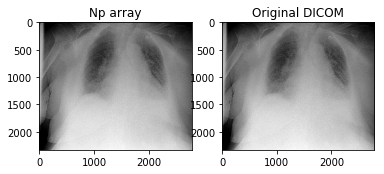

In [31]:
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='gray')
plt.title('Np array')

plt.subplot(1, 2, 2)
plt.imshow(dicom.pixel_array, cmap='gray')
plt.title('Original DICOM')

# Transform all images into PNG

Needs to run with py2gdcm for some images, that throw error:

`"The following handlers are available to decode the pixel data however they are missing required dependencies: GDCM (req. GDCM)"`

In [65]:
from tqdm.auto import tqdm
from PIL import Image
from collections import defaultdict

In [ ]:
errors = defaultdict(list)
dtypes_by_image = dict()

In [ ]:
# took ~1h for test split, ~6h for train split

In [ ]:
for split in ('test', 'train'):
    fpaths = glob(os.path.join(DICOM_DIR, split, '*/*/*.dcm'))

    for fpath in tqdm(fpaths):
        # Get png fpath
        filename = fpath.replace(DICOM_DIR, '')
        if filename.startswith('/'):
            filename = filename[1:]
        out_fpath = os.path.join(DATASET_DIR, 'images-16bit', filename)
        out_fpath = out_fpath.replace('.dcm', '.png')
        
        if os.path.isfile(out_fpath):
            continue
        
        # Ensure folder exists
        out_folder = os.path.dirname(out_fpath)
        if not os.path.isdir(out_folder):
            os.makedirs(out_folder)
            # Cannot use exist_ok=True in python 2
        
        dicom = pydcm.read_file(fpath)
        
        # Save dtype
        dtypes_by_image[filename] = str(dicom.pixel_array.dtype)

        # Transform tu numpy
        try:
            data = dicom_to_np(dicom)
        except Exception as e:
            errors['to-np'].append((fpath, e))
            continue

        # Choose image mode (8bit or 16bit)
        if data.dtype == np.uint8:
            mode = 'L'
        elif data.dtype == np.uint16:
            mode = 'I;16'
        else:
            errors['dtype'].append((fpath, data.type))
            continue
        
        image = Image.fromarray(data, mode=mode)
        
        # Save as png
        image.save(out_fpath, optimize=True)
        image.close()

In [85]:
from collections import Counter
import json

In [96]:
with open(os.path.join(DATASET_DIR, 'dtypes_by_image.json'), 'w') as f:
    json.dump(dtypes_by_image, f, indent=2)

In [84]:
Counter(dtypes_by_image.values())

Counter({'uint16': 7118, 'uint8': 479})

In [79]:
unique_exceptions = set(str(e) for f, e in errors['to-np'])
unique_exceptions

set()

In [237]:
error_fpaths = [f for f, e in errors['to-np']]
len(error_fpaths)

550

In [ ]:
error_fpaths

# Save images-small

Save into folder images-256

In [15]:
from torchvision.transforms import Resize

In [12]:
%run ../../utils/images.py

In [ ]:
errors = []
resizer = Resize((256, 256))

for split in ('train', 'test'):
    fpaths = glob(os.path.join(DATASET_DIR, 'images', split, '*/*/*.png'))

    for fpath in tqdm(fpaths):
        target_fpath = fpath.replace('/images/', '/images-256/')
        
        if os.path.isfile(target_fpath):
            continue
        
        # Create folder
        target_folder = os.path.dirname(target_fpath)
        os.makedirs(target_folder, exist_ok=True)
            
        # Load large image
        src_image = load_image(fpath, 'RGB')
        
        # Resize to 256
        target_image = resizer(src_image)
        
        # Save
        target_image.save(target_fpath)

# Compute mean and std

In [17]:
%run ../../utils/images.py

In [21]:
TRAIN_IMAGE_PATHS = glob(os.path.join(DATASET_DIR, 'images', 'train/*/*/*.png'))
len(TRAIN_IMAGE_PATHS)

6334

In [22]:
mean, std = compute_mean_std(
    ImageFolderIterator(os.path.join(DATASET_DIR, 'images'), TRAIN_IMAGE_PATHS),
    show=True,
)
mean, std

  0%|          | 0/6334 [00:00<?, ?it/s]

(tensor([0.5234, 0.5234, 0.5234]), tensor([0.2099, 0.2099, 0.2099]))

# Debug dataset class

In [115]:
%run ../covid_siim.py

In [133]:
dataset = CovidSiimDataset('test')
len(dataset)

1263

In [134]:
item = dataset[10]

In [135]:
item.image.size(), item.bboxes, item.labels

(torch.Size([3, 512, 512]), [], tensor([0, 0, 0, 0], dtype=torch.uint8))